# Denoising

I modifified the initial function generate_dataset_classification, so that when it is called it returns one set of images with noise and a second set, which is the equivalent, but without noise. At this point I trained on a functional model the noisy set on the clean one. I also predicted the values of the training set and plotted the comparison of the first image with the two equivalent in the original sets.

In [174]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata2 = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return [imdata,imdata2]

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]




def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            myx=generate_a_rectangle(noise, free_location)
            X[i] = myx[0]
            Y[i]=myx[1]
        elif category == 1:
            myx=generate_a_disk(noise, free_location)
            X[i] = myx[0]
            Y[i]=myx[1]
        else:
            myx=generate_a_triangle(noise, free_location)
            X[i] = myx[0][0]
            Y[i]=myx[0][1]
        
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3)
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



In [175]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [176]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, UpSampling2D
import os
import numpy as np
import zipfile
from urllib import request
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
%matplotlib inline


from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model

input_img = Input(shape=( 72, 72,1))
x = Convolution2D(32, 3, 3, border_mode='same')(input_img)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)

x = Convolution2D(32, 3, 3, border_mode='same')(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same')(x)

funcmodel = Model(input_img, x)
funcmodel.compile(optimizer='adadelta', loss='binary_crossentropy')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="same")`
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (3, 3), activation="sigmoid", padding="same")`


In [177]:
X_train= X_train.reshape(300,72,72,1)

In [178]:
Y_train= Y_train.reshape(300,72,72,1)

In [179]:
funcmodel.fit(Y_train,
              X_train,
              nb_epoch=10,
              batch_size=32,
              shuffle=True,
              validation_split=.20)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 240 samples, validate on 60 samples
Epoch 1/10
240/240 [==============================] - 5s 19ms/step - loss: 2.4288 - val_loss: 1.4665
Epoch 2/10
240/240 [==============================] - 4s 15ms/step - loss: 1.4435 - val_loss: 1.3292
Epoch 3/10
240/240 [==============================] - 4s 15ms/step - loss: 1.0871 - val_loss: 0.9843
Epoch 4/10
240/240 [==============================] - 4s 16ms/step - loss: 1.0862 - val_loss: 0.9834
Epoch 5/10
240/240 [==============================] - 4s 15ms/step - loss: 0.9727 - val_loss: 0.9669
Epoch 6/10
240/240 [==============================] - 4s 15ms/step - loss: 1.0174 - val_loss: 0.9672
Epoch 7/10
240/240 [==============================] - 4s 15ms/step - loss: 1.0014 - val_loss: 0.9565
Epoch 8/10
240/240 [==============================] - 4s 17ms/step - loss: 2.3713 - val_loss: 0.9852
Epoch 9/10
240/240 [==============================] - 4s 15ms/step - loss: 1.5829 - val_loss: 1.0999
Epoch 10/10
240/240 [=========================

In [180]:
f1 = funcmodel.predict(Y_train)

In [185]:
f1[0].shape


(72, 72, 1)

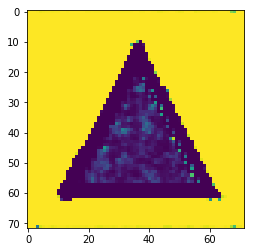

In [186]:
plt.imshow(f1[1].reshape(72,72))

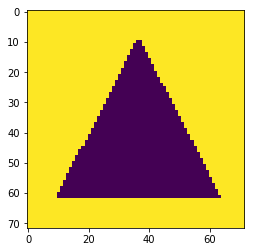

In [187]:
plt.imshow(X_train[1].reshape(72,72))

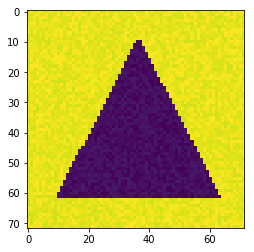

In [188]:
plt.imshow(Y_train[1].reshape(72,72))